In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle

import os
import sys
import annoy
from annoy import AnnoyIndex
import random



from IPython.display import display_markdown

from collections import Counter

from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial import cKDTree
from sklearn.decomposition import PCA
from sklearn.decomposition import SparsePCA


import antares_client

import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# set random seed for consistent results
import random
random.seed(0)

plt.style.use('fig_publication.mplstyle')
%config InlineBackend.figure_format = 'retina'  #for MacOS, make plots crisp

In [2]:
suffix="noTNScut_pca35_noCadence_NOtransf_HasHostGalOnly_MaxAbs_AlerceCls_fw_MI_classif_LConly_hostdownweighted_SMOTE_80-20" # !! Really nice. Same/better results with less PCs. 98% var.

#suffix="noTNScut_pca45_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls_fw_MI_classif_LConly_hostdownweighted_SMOTE_80-20" #really v good, better than 35pca (best PC implementation)


In [3]:
dataset_bank_pca = pd.read_csv(f'../dataframes/{suffix}_dataset_bank_pca.csv', compression='gzip', index_col=0)
dataset_bank_test = pd.read_csv(f'../dataframes/{suffix}_dataset_bank_pca_test.csv', compression='gzip', index_col=0)

In [4]:
dataset_bank_pca

,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,...,PC25,PC26,PC27,PC28,PC29,PC30,PC31,PC32,PC33,PC34
ztf_object_id,,,,,,,,,,,,,,,,,,,,,
ZTF19ackimld,0.847744,0.338321,-0.071262,3.082952,2.092895,-0.453676,0.345815,-0.299243,-0.926570,0.034622,...,0.309963,0.343602,-0.036266,-0.280046,0.319726,-0.028270,0.168196,-0.206431,-0.175266,0.251925
ZTF20acoxdas,-0.733537,-0.284973,-0.174785,-0.215826,-0.832408,0.192899,-0.128619,0.304362,-0.146194,-0.335320,...,-0.117765,0.064517,-0.040453,0.096104,-0.085822,-0.092986,-0.033111,-0.017519,-0.059353,-0.001735
ZTF20acibvgy,2.157246,-1.315718,-0.522463,0.098561,0.278114,0.095379,0.095281,0.917424,-0.398184,-0.127172,...,-0.139684,-0.025743,0.087323,0.171666,0.037707,0.193086,0.035224,0.208283,0.089503,0.263231
ZTF20acbrlih,-0.568429,-1.827048,0.047540,0.644075,0.179118,-1.113239,0.879092,-0.695281,-0.556925,0.277943,...,0.115675,0.098528,0.008993,0.157850,-0.184164,-0.132336,-0.186208,0.013148,-0.262696,-0.128860
ZTF19aadfqfw,0.507054,-0.292718,-1.682916,-1.051947,-0.209582,0.830198,0.631722,0.698900,-0.485004,-0.660629,...,-0.233172,0.090728,-0.373098,-0.040222,-0.308331,-0.196168,0.304524,-0.027600,0.296905,0.016995
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZTFabc66040,1.312456,0.212597,-0.978550,1.546475,0.518040,-0.389238,-0.134513,0.047149,0.115422,0.178552,...,-0.095422,-0.031200,0.074899,0.125596,-0.169857,-0.060402,0.012632,-0.027986,0.013490,0.018789
ZTFabc65041,-1.035885,1.938226,0.350370,1.909906,0.535570,-0.398688,0.215395,0.343606,-0.113521,0.327850,...,0.072913,-0.188557,-0.053535,-0.051384,-0.127826,-0.053748,0.019392,0.103017,-0.144196,-0.030089
ZTFabc79012,-1.377666,1.562061,0.668220,0.447351,-0.608666,-0.065088,0.205432,0.336315,-0.379787,-0.384058,...,-0.124106,-0.113424,-0.092712,0.034725,0.081108,0.119629,0.050273,0.080092,0.024048,0.002287


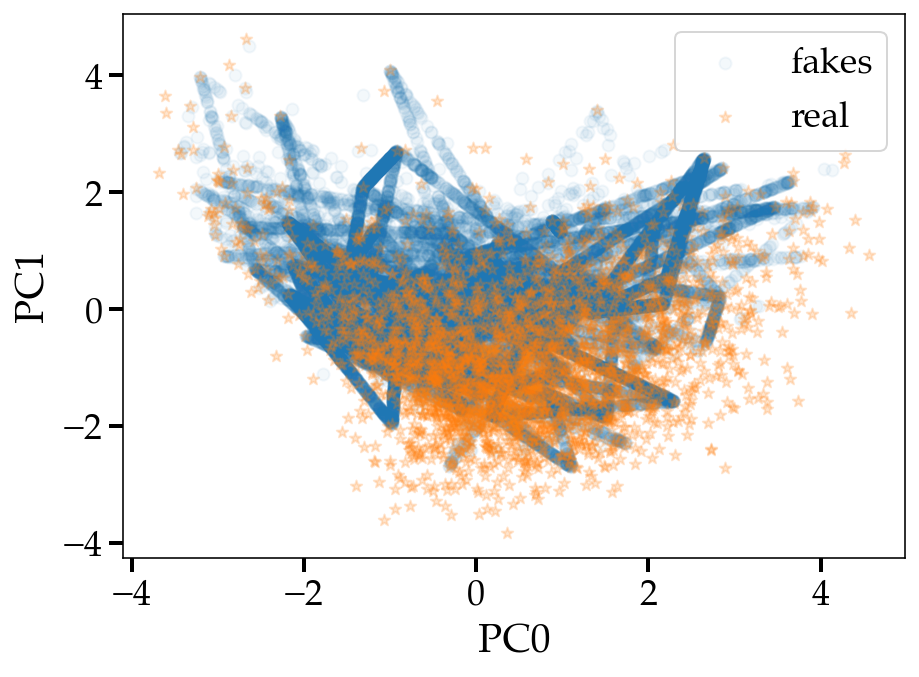

In [5]:
fig, ax = plt.subplots()

# Split into real/fakes
real_df = dataset_bank_pca[~dataset_bank_pca.index.str.startswith('ZTFabc')]
fakes_df = dataset_bank_pca[dataset_bank_pca.index.str.startswith('ZTFabc')]

ax.scatter(fakes_df['PC0'], fakes_df['PC1'], alpha=0.05, marker='o', label='fakes')
ax.scatter(real_df['PC0'], real_df['PC1'], alpha=0.2, marker='*',label='real')

plt.xlabel('PC0')
plt.ylabel('PC1')

plt.legend()
plt.show()

In [6]:
# not upsampling None (no fakes), and few Ia fakes, so fakes doesn't cover all regions
# But fakes does cover outlier regions
# streaks are from extreme upsampling of O(few) instances of minority classes with 2knn

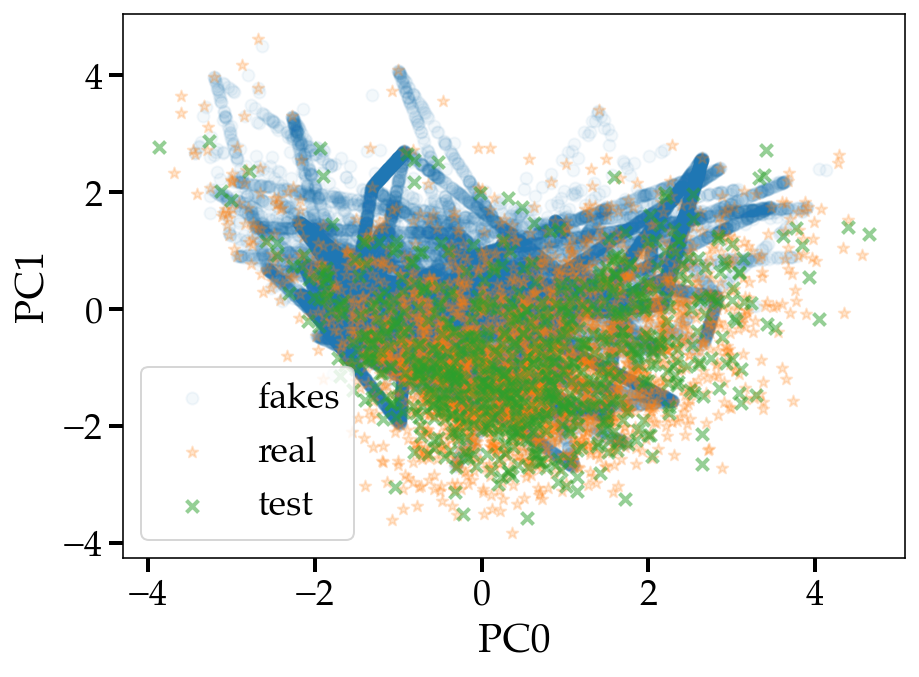

In [7]:
fig, ax = plt.subplots()

# Split into real/fakes
real_df = dataset_bank_pca[~dataset_bank_pca.index.str.startswith('ZTFabc')]
fakes_df = dataset_bank_pca[dataset_bank_pca.index.str.startswith('ZTFabc')]
test_df = dataset_bank_test

ax.scatter(fakes_df['PC0'], fakes_df['PC1'], alpha=0.05, marker='o', label='fakes')
ax.scatter(real_df['PC0'], real_df['PC1'], alpha=0.2, marker='*',label='real')
ax.scatter(test_df['PC0'], test_df['PC1'], alpha=0.5, marker='x',label='test')

plt.xlabel('PC0')
plt.ylabel('PC1')

plt.legend()
plt.show()

In [10]:
cut_df = test_df[(test_df['PC1'] > 2)]
cut_df

,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,...,PC25,PC26,PC27,PC28,PC29,PC30,PC31,PC32,PC33,PC34
ztf_object_id,,,,,,,,,,,,,,,,,,,,,
ZTF18abaeqpf,-0.805993,2.551071,-1.050533,-0.581114,-0.905080,-0.867937,0.039831,0.250023,0.344344,0.289145,...,0.060634,0.069610,-0.024840,-0.108993,-0.182797,-0.013086,-0.189028,-0.058936,-0.157333,-0.082398
ZTF18actuhrs,-0.806347,2.177022,0.996888,-2.286472,-0.288455,0.294806,0.217469,0.198480,-0.047499,-0.500862,...,-0.101138,-0.104473,0.347041,0.114897,-0.209666,0.063231,0.191846,0.068737,0.104232,-0.060083
ZTF21aautijg,3.391448,2.289251,0.612546,-0.035435,-0.319647,0.248602,-0.169251,0.997019,0.293623,0.165573,...,0.311868,-0.048128,-0.293279,-0.020826,0.068747,-0.107237,0.113112,0.101678,-0.065097,-0.142766
ZTF20acurome,3.323311,2.245641,-0.362012,-0.381184,0.263091,-0.070533,0.248746,0.482755,0.298800,-0.435654,...,-0.075991,-0.107960,-0.288853,-0.177966,0.186348,0.006291,-0.127981,0.187440,0.047314,0.459806
ZTF20acggqfs,-3.869823,2.766147,-0.297533,-2.100187,0.711838,1.039174,0.816618,0.377654,0.627656,1.011085,...,-0.078758,0.266990,-0.145578,0.084504,-0.282354,0.077108,-0.113247,0.332221,0.356135,0.054448
ZTF18abdhozj,-1.938556,2.751020,-0.323827,-0.292239,-1.275777,2.345147,0.003803,0.935294,-0.264171,0.033208,...,-0.642643,0.204074,0.335571,-0.237420,0.131921,-0.267706,0.243526,-0.070230,-0.308270,0.102859
ZTF20acgrvqo,-1.903535,2.284842,-0.392700,1.322206,1.584638,0.717791,-0.262950,0.104926,-1.020282,-0.175831,...,0.110701,-0.480739,0.018115,-0.013918,-0.140255,0.216302,-0.081516,0.105305,-0.009802,-0.039581
ZTF20aasuiks,-3.270756,2.883122,-0.800040,0.139181,-1.170753,0.531445,0.636496,0.903201,-0.884371,-0.041876,...,0.612920,0.108623,0.163844,0.006275,0.039877,0.187682,0.131643,0.108914,0.584100,0.044786
ZTF20acqucpz,-0.898172,2.661605,0.744626,0.100795,0.277874,3.748575,0.115139,-0.413599,-0.618436,-0.913860,...,-0.313276,-0.228440,0.406143,0.369705,-0.279365,-0.172785,0.220654,-0.166482,-0.015118,0.044825


In [11]:
for sn in cut_df.index:
    print(f'https://alerce.online/object/{sn}')

https://alerce.online/object/ZTF18abaeqpf
https://alerce.online/object/ZTF18actuhrs
https://alerce.online/object/ZTF21aautijg
https://alerce.online/object/ZTF20acurome
https://alerce.online/object/ZTF20acggqfs
https://alerce.online/object/ZTF18abdhozj
https://alerce.online/object/ZTF20acgrvqo
https://alerce.online/object/ZTF20aasuiks
https://alerce.online/object/ZTF20acqucpz
https://alerce.online/object/ZTF20abxybag
https://alerce.online/object/ZTF20ablygyy
https://alerce.online/object/ZTF21aazrgtw
https://alerce.online/object/ZTF20acifwef
https://alerce.online/object/ZTF21aaifyvi


In [ ]:
#suffix="noTNScut_pca45_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls_fw_MI_classif_LConly_hostdownweighted_SMOTE_80-20"

In [8]:
# train/test before smote has same embedding mostly
# smote covers regions it's supposed to

In [9]:
test_df[(test_df['PC0'] > 20) & (test_df['PC1'] < -20)]

,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,...,PC35,PC36,PC37,PC38,PC39,PC40,PC41,PC42,PC43,PC44
ztf_object_id,,,,,,,,,,,,,,,,,,,,,
ZTF18abdhozj,25.439574,-24.951532,-2.289450,-1.543053,8.712697,13.600060,9.649984,3.869568,4.551081,11.338575,...,-2.061275,-1.159206,2.072201,-1.499257,3.160417,-0.356336,-4.214589,-0.216824,-0.298517,-0.253958
ZTF20acqucpz,26.229254,-23.538925,-0.321443,0.806727,4.703218,15.257168,7.076477,0.900906,5.578813,0.524005,...,-2.160591,4.382718,-1.586468,-2.776953,2.010616,2.089904,-1.223640,1.944034,-2.499293,1.632205


In [10]:
# https://alerce.online/object/ZTF18abdhozj - remaining periodic var
# https://alerce.online/object/ZTF20acqucpz - remaining CV

In [12]:
real_df[(real_df['PC0'] < -20) & (real_df['PC1'] > 15)]

,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,...,PC35,PC36,PC37,PC38,PC39,PC40,PC41,PC42,PC43,PC44
ztf_object_id,,,,,,,,,,,,,,,,,,,,,
ZTF21abdtkdc,-22.163253,22.511544,-7.627958,-2.259726,-3.433426,-2.808574,-4.373169,0.230342,6.517101,-1.174292,...,1.207785,-0.965603,2.253548,1.345902,-2.990527,-1.364164,-2.640205,0.319725,-1.411165,-0.142190
ZTF21aarvysz,-20.838052,19.716343,-11.223825,-9.730916,-4.214124,-2.776630,-2.469222,4.432431,3.459800,-0.015755,...,-0.822607,0.529747,2.099676,0.324822,-0.193822,-0.413322,-3.663055,1.086797,-0.874276,-0.521186
ZTF21aardzlu,-20.609653,17.887838,-1.452162,-1.571780,5.446219,-0.511114,-2.816245,-0.564413,3.411933,1.063307,...,0.949911,-0.015324,-1.113844,-0.854960,0.542895,-1.589053,-0.632498,0.795945,-1.980645,-0.460658


In [ ]:
# all 3 are flat LCs with None tns spec class

In [14]:
test_df[(test_df['PC0'] < 10) & (test_df['PC1'] > 20)]

,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,...,PC35,PC36,PC37,PC38,PC39,PC40,PC41,PC42,PC43,PC44
ztf_object_id,,,,,,,,,,,,,,,,,,,,,
ZTF18abwxrhi,4.527623,21.511848,18.555454,11.050699,4.83806,-4.791629,21.238319,19.539585,-4.750731,-5.895489,...,-2.344125,-2.972335,3.366347,-0.763277,-1.839438,-1.142456,3.152264,1.380873,2.985124,3.431534


In [ ]:
# https://alerce.online/object/ZTF18abwxrhi
# that weird maybe double peak SN / bogus second bump obs

In [16]:
test_df[(test_df['PC0'] < -25) & (test_df['PC1'] < -10)]

,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,...,PC35,PC36,PC37,PC38,PC39,PC40,PC41,PC42,PC43,PC44
ztf_object_id,,,,,,,,,,,,,,,,,,,,,
ZTF18aaqdlle,-29.344679,-11.608744,10.294377,-2.510227,26.038514,2.667018,0.422067,5.172922,3.517185,-0.851667,...,-2.391525,-1.821549,-0.830398,-0.426677,0.503373,0.106479,-1.140716,0.549167,-2.004430,1.444579
ZTF18acclacc,-29.015988,-16.451279,5.987124,1.856043,21.864505,-1.625007,3.249946,9.712309,5.493366,2.360775,...,-2.382828,0.074992,0.530949,-1.617456,-0.956524,-2.599603,-0.943605,0.078554,-2.304119,0.805382


In [ ]:
# SN in template images

In [17]:
test_df[(test_df['PC0'] < -20) & (test_df['PC1'] < -10)]

,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,...,PC35,PC36,PC37,PC38,PC39,PC40,PC41,PC42,PC43,PC44
ztf_object_id,,,,,,,,,,,,,,,,,,,,,
ZTF21aasttsm,-20.298472,-11.896813,11.995602,-11.060080,1.215294,-1.563570,-3.610145,-6.124563,1.568291,3.397161,...,2.120320,1.851662,0.597470,0.474003,-1.956241,0.637700,1.965622,3.005612,-1.149632,-0.702561
ZTF21abrduyv,-24.222897,-14.482757,9.234705,3.250013,3.324799,1.948191,-2.928338,0.997722,-3.465844,0.748486,...,1.806170,0.148293,-2.418226,1.868700,-3.024807,0.368600,0.244908,-0.247381,0.245462,1.318686
ZTF21aaqhxvc,-22.256702,-14.075184,3.824647,7.586351,3.233600,-0.435544,1.882573,-0.221733,2.065071,-0.445902,...,-0.848070,0.833937,-3.098243,-0.176281,0.424199,0.163895,1.152259,-1.147861,-0.593108,1.061885
ZTF18aaqdlle,-29.344679,-11.608744,10.294377,-2.510227,26.038514,2.667018,0.422067,5.172922,3.517185,-0.851667,...,-2.391525,-1.821549,-0.830398,-0.426677,0.503373,0.106479,-1.140716,0.549167,-2.004430,1.444579
ZTF18acclacc,-29.015988,-16.451279,5.987124,1.856043,21.864505,-1.625007,3.249946,9.712309,5.493366,2.360775,...,-2.382828,0.074992,0.530949,-1.617456,-0.956524,-2.599603,-0.943605,0.078554,-2.304119,0.805382
ZTF21abcwnub,-20.716612,-10.193120,2.729436,-3.701176,0.192830,-1.169605,-1.817422,1.924119,-2.593268,-0.191790,...,0.801612,-0.347447,-1.637663,0.352083,-1.687103,-0.606164,1.077189,-0.676988,0.659723,-1.162769


In [ ]:
# ALL ZTF21 LCs are rising and top out before 2nd peak, tightly sampled Ia in small elliptical galaxies

# 2 PCs (43% of variance) do pretty good job.